# **Mô hình LSTM**

## **Thư viện**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from keras.regularizers import l2
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json
import os

## **Dữ liệu**

In [17]:
file_path = "..//data//processed//EUR_VND_Exchange_Rate_2020_2025_clean.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Sell']]
data.head()



,Sell
Date,
2020-04-01,26506.55
2020-04-02,26506.55
2020-04-03,25936.23
2020-04-04,25936.23
2020-04-05,25936.23


## **Chuẩn hóa dữ liệu**

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

## **Tạo dữ liệu chuỗi cho LSTM**

In [19]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

## **Chia train/test**

In [20]:
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

## **Tìm kiếm tham số tốt nhất**

In [21]:
import os

base_dir = r"..\model"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
base_dir = os.path.normpath(os.path.join("..", "model"))
directory = os.path.join(base_dir, "LSTM")
if not os.path.exists(directory):
    os.makedirs(directory)


In [22]:
def build_lstm_model(hp, seq_length=30):
    model = Sequential()
    model.add(Input(shape=(seq_length, 1)))
    model.add(LSTM(
        units=hp.Choice("lstm_units", [32, 64, 96]),
        activation=hp.Choice("activation", ['relu', 'tanh']),
        return_sequences=False,
        kernel_regularizer=l2(hp.Choice("l2_reg", [0.001, 0.01]))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice("dropout", [0.2, 0.3, 0.4])))
    model.add(Dense(hp.Choice("dense_units", [16, 32, 64]), activation="relu"))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.001, 0.0005])),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [23]:
directory = "my_tuner"  
tuner = kt.RandomSearch(
    build_lstm_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory=directory,
    project_name="lstm_best",
    overwrite=True
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=2
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_lstm_model(best_hp, seq_length)
best_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=2
)

save_dir = os.path.join("..", "model", "LSTM")
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "best_lstm.h5")
best_model.save(model_path)
print(f"Model tốt nhất đã lưu tại: {model_path}")


Trial 10 Complete [00h 00m 41s]
val_loss: 0.0013081793440505862

Best val_loss So Far: 0.0006286297575570643
Total elapsed time: 00h 06m 52s
Epoch 1/30
46/46 - 6s - 124ms/step - loss: 0.0976 - mae: 0.2445 - val_loss: 0.1572 - val_mae: 0.3851
Epoch 2/30
46/46 - 1s - 31ms/step - loss: 0.0199 - mae: 0.0969 - val_loss: 0.0600 - val_mae: 0.2252
Epoch 3/30
46/46 - 1s - 28ms/step - loss: 0.0129 - mae: 0.0813 - val_loss: 0.0456 - val_mae: 0.1917
Epoch 4/30
46/46 - 1s - 30ms/step - loss: 0.0087 - mae: 0.0679 - val_loss: 0.0474 - val_mae: 0.1969
Epoch 5/30
46/46 - 1s - 26ms/step - loss: 0.0072 - mae: 0.0621 - val_loss: 0.0377 - val_mae: 0.1731
Epoch 6/30
46/46 - 1s - 28ms/step - loss: 0.0057 - mae: 0.0553 - val_loss: 0.0389 - val_mae: 0.1778
Epoch 7/30
46/46 - 1s - 30ms/step - loss: 0.0053 - mae: 0.0528 - val_loss: 0.0455 - val_mae: 0.1971
Epoch 8/30
46/46 - 1s - 28ms/step - loss: 0.0061 - mae: 0.0583 - val_loss: 0.0242 - val_mae: 0.1372
Epoch 9/30
46/46 - 1s - 26ms/step - loss: 0.0052 - mae: 0.

Model tốt nhất đã lưu tại: ..\model\LSTM\best_lstm.h5


In [24]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("LSTM units:", best_hp.get("lstm_units"))
print("L2 reg:", best_hp.get("l2_reg"))
print("Dropout:", best_hp.get("dropout"))
print("Dense units:", best_hp.get("dense_units"))
print("Learning rate:", best_hp.get("learning_rate"))



LSTM units: 64
L2 reg: 0.001
Dropout: 0.2
Dense units: 16
Learning rate: 0.001


## **Huấn luyện**

In [26]:
from tensorflow.keras.models import load_model
best_model = load_model(r"..\model\LSTM\best_lstm.h5", compile=False)

## **Dự đoán trên tập val**

In [27]:
y_pred = best_model.predict(X_val)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


## **Đánh giá mô hình**

In [28]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
mape = (abs((y_val - y_pred) / y_val)).mean() * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape} %")


MAE: 0.015827806785146625
MSE: 0.0004811611714523203
RMSE: 0.02193538628454763
MAPE: 2.247931821618482 %


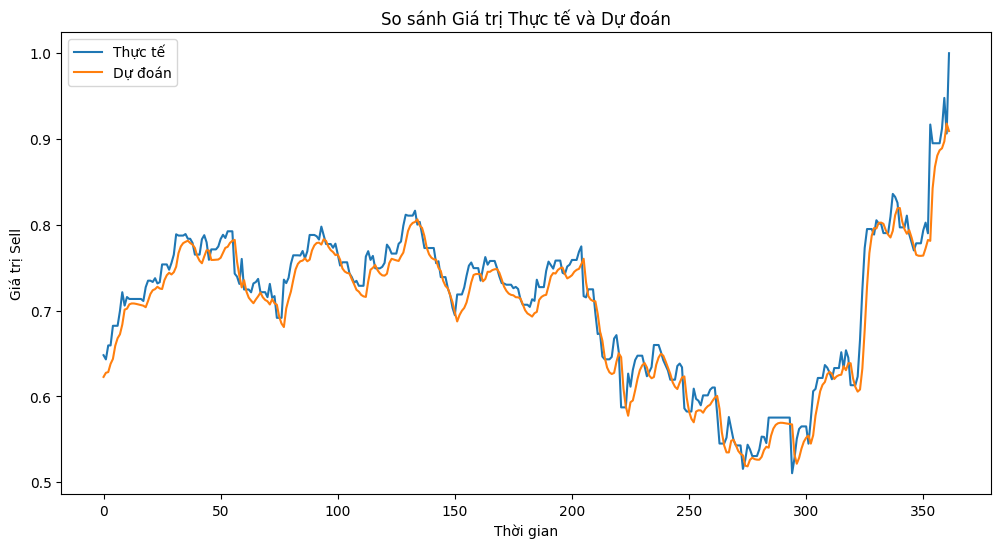

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_val, label="Thực tế")
plt.plot(y_pred, label="Dự đoán")
plt.title("So sánh Giá trị Thực tế và Dự đoán")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị Sell")
plt.legend()
plt.show()


In [30]:
from datetime import timedelta

def predict_future_with_dates(model, last_sequence, last_date, n_steps):
    future_predictions = []
    future_dates = []
    current_sequence = last_sequence.copy()
    
    for i in range(n_steps):
        current_pred = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(current_pred[0, 0])
        
        next_date = last_date + timedelta(days=i+1)
        future_dates.append(next_date)
    
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, 0] = current_pred
        
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
 
    result_df = pd.DataFrame({
        'Ngày': future_dates,
        'Giá trị Sell dự đoán': future_predictions.flatten()
    })
    
    return result_df

# Lấy sequence cuối cùng và ngày cuối cùng từ dữ liệu
last_sequence = X_val[-1]
last_date = data.index[-1] 
future_predictions_df = predict_future_with_dates(best_model, last_sequence, last_date, 7)

print("Dự đoán 7 ngày tiếp theo:")
print(future_predictions_df.to_string(index=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


C:\Users\nguyetnt\AppData\Local\Temp\ipykernel_3676\3109299002.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 0] = current_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Dự đoán 7 ngày tiếp theo:
      Ngày  Giá trị Sell dự đoán
2025-04-12          29197.207031
2025-04-13          29166.705078
2025-04-14          29130.466797
2025-04-15          29089.949219
2025-04-16          29046.041016
2025-04-17          28998.521484
2025-04-18          28947.439453
